In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from archimedean_copulas import copulas

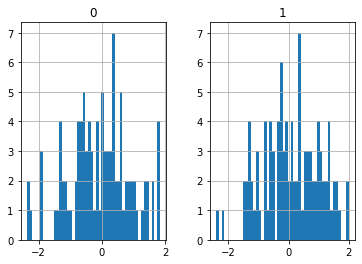

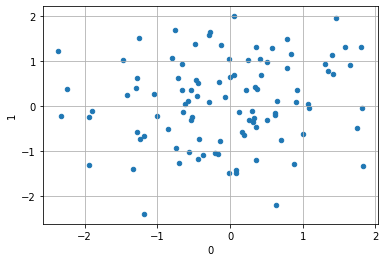

In [14]:
SEED = 0
rng = np.random.default_rng(SEED)
rets = pd.DataFrame(rng.standard_normal((100, 2)))

scat = {'x': 0, 'y': 1}
rets.hist(bins=50)
_ = rets.plot.scatter(**scat, grid=True)

,0,1
count,100.000000,100.000000
mean,0.505000,0.505000
std,0.290115,0.290115
min,0.010000,0.010000
25%,0.257500,0.257500
50%,0.505000,0.505000
75%,0.752500,0.752500
max,1.000000,1.000000


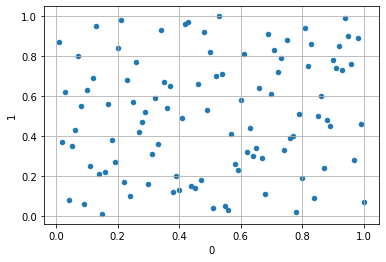

In [11]:
def edf(rets):
    return rets.rank(method='min', pct=True).values

edfs = edf(rets)
edf_0, edf_1 = edfs[:, 0], edfs[:, 1]
pd.DataFrame(edfs).plot.scatter(**scat, grid=True)
pd.DataFrame(edfs).describe()

In [ ]:
methods = [
    'Nelder-Mead',
    'Powell',
    'CG',
    'BFGS',
    'L-BFGS-B',
    'TNC',
    'COBYLA',
    'SLSQP',
]

def pseudo_max_likelihood(copula, edf_0, edf_1, method):
    minus_log_likelihood = lambda theta: np.sum(-np.log(copula(edf_0, edf_1, theta)))
    res = dict(minimize(minus_log_likelihood, x0=1, method=method))
    res['x'] = res['x'][0]
    res['method'] = method
    return pd.Series(res)

pseudo_max_likelihood(copulas['04'][0], edf_0, edf_1, methods[0])

In [ ]:
def fit_copula(copula, edf_0, edf_1):
    optims = [
        pseudo_max_likelihood(copula, edf_0, edf_1, method)
        for method in methods]
    cols = {
        'fun': 'float', 'nit': 'float', 'nfev': 'int', 'status': 'int',
        'success': 'bool', 'message': 'object', 'method': 'object', 'x': 'float'
    }
    acceptable = pd.concat(optims, axis=1).T.loc[:, cols.keys()].astype(cols)
    acceptable = acceptable[
        acceptable['fun'].apply(np.isfinite)
        & acceptable['nit'].gt(1)
        & acceptable['success']
        & acceptable['message'].str.contains('Optimization terminated successfully')
    ]
    return None if acceptable.empty or len(acceptable) < 3 else acceptable['x'].median()

fit_copula(copulas['04'][0], edf_0, edf_1)

In [ ]:
def generator(fun, der, ttt, theta):
    return ttt - fun(ttt, theta) / der(ttt, theta)

def ks_dist(left, right):
    return (left - right).abs().max()

def assess_fit(name, theta, edf_0, edf_1):
    if theta is None or theta < copulas[name][1]:
        dist = np.nan
    else:
        vals = copulas[name][0](edf_0, edf_1, theta)
        dfs = pd.Series(vals).rename('vals_copula').to_frame()
        dfs['empirical'] = edf(dfs['vals_copula'])
        dfs['theoretical'] = generator(copulas[name][2], copulas[name][3], vals, theta)
        dist = ks_dist(dfs['empirical'], dfs['theoretical'])
    return name, theta, dist

fits = {
    name: fit_copula(defi[0], edf_0, edf_1)
    for name, defi in copulas.items()}
data = [
    assess_fit(name, theta, edf_0, edf_1)
    for name, theta in fits.items()]
fits_quality = pd.DataFrame(data=data, columns=['name', 'theta', 'KS_dist'])
fits_quality

In [ ]:
def fit_archimedean_copula(rets_0, rets_1):
    edf_0 = edf(rets_0)
    edf_1 = edf(rets_1)
    fits = {
        name: fit_copula(defi[0], edf_0, edf_1)
        for name, defi in copulas.items()}
    fits_quality = [
        assess_fit(name, theta, edf_0, edf_1)
        for name, theta in fits.items()]
    fits_quality = pd.DataFrame(
        data=fits_quality, columns=['name', 'theta', 'KS_dist'])
    remaining = fits_quality.dropna()
    return remaining.iloc[remaining['KS_dist'].argmin()] if not remaining.empty else None

fit_archimedean_copula(rets.loc[:, 0], rets.loc[:, 1])